In [254]:
#Load libraries
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime

In [255]:
import matplotlib.pyplot as plt

In [256]:
%matplotlib inline

In [258]:
#Load data
data = pd.read_csv("orders_data.csv")
print(data.shape)
data.head(2)

(146874, 16)


,exchange_rate_date,invoice,customer,id,state,order,createdAt,location,segmentation,NetTotalAfterDiscount,NetTotalBeforeDiscount,GrossTotalAfterDiscount,GrossTotalBeforeDiscount,currency_code,exchange_rate_value,isvalid
0,2014-10-22,NaN,GB-CUS-Y8922200,54478738d2cde8320d9b58d2,canceled,GB-A-69332,2014-10-22 12:30:16,gb_london,NaN,NaN,NaN,NaN,NaN,GBP,0.788134,0
1,2014-10-22,NaN,GB-CUS-K3854440,54478fa5d4cde82847f1345e,canceled,GB-A-74327,2014-10-22 13:06:13,gb_london,DCLA,NaN,NaN,NaN,NaN,GBP,0.788134,0


In [259]:
#Make a subset
data_s = data[["customer","state","order","createdAt","location"]]

In [260]:
#Add the data, just in case
data_s.is_copy = False #turn off the check for that object
#data_s["date"] = pd.to_datetime(data_s["createdAt"]) #that form would keep the timestamp
data_s["date"] = pd.to_datetime(data_s["createdAt"]).dt.date #that parses the date part 
data_s['date'] = pd.to_datetime(data_s['date'])
print(data_s.dtypes)
data_s.head()

customer             object
state                object
order                object
createdAt            object
location             object
date         datetime64[ns]
dtype: object


,customer,state,order,createdAt,location,date
0,GB-CUS-Y8922200,canceled,GB-A-69332,2014-10-22 12:30:16,gb_london,2014-10-22
1,GB-CUS-K3854440,canceled,GB-A-74327,2014-10-22 13:06:13,gb_london,2014-10-22
2,GB-CUS-Y8922200,canceled,GB-R-37069,2014-10-22 12:34:35,gb_london,2014-10-22
3,GB-CUS-C3589820,canceled,GB-G-10354,2014-10-22 20:04:20,gb_london,2014-10-22
4,GB-CUS-P6345195,completed,GB-X-54771,2014-10-22 12:24:29,gb_london,2014-10-22


In [261]:
#Check the set of unique states
print(data_s['state'].unique())

#Add is_valid column
data_s["isvalid"] = 1
data_s.ix[data_s['state'].isin(['new','canceled','reserved']),['isvalid']] = 0

#Check total # of valid orders
print("Total number of valid orders: ", sum(data_s["isvalid"]))
print("Unique customers: ", len(data_s['customer'].unique()))
print(data_s.shape)
data_s.head()

['canceled' 'completed' 'payment_error' 'processing'
 'payment_settlement_cycle' 'reserved']
Total number of valid orders:  123970
Unique customers:  37310
(146874, 7)


,customer,state,order,createdAt,location,date,isvalid
0,GB-CUS-Y8922200,canceled,GB-A-69332,2014-10-22 12:30:16,gb_london,2014-10-22,0
1,GB-CUS-K3854440,canceled,GB-A-74327,2014-10-22 13:06:13,gb_london,2014-10-22,0
2,GB-CUS-Y8922200,canceled,GB-R-37069,2014-10-22 12:34:35,gb_london,2014-10-22,0
3,GB-CUS-C3589820,canceled,GB-G-10354,2014-10-22 20:04:20,gb_london,2014-10-22,0
4,GB-CUS-P6345195,completed,GB-X-54771,2014-10-22 12:24:29,gb_london,2014-10-22,1


# Preparation part

In [262]:
#Aggregate by customer
g = data_s[data_s['isvalid']>0].groupby('customer').apply(lambda x: x['isvalid'].sum()).reset_index()

In [263]:
g.columns = ['customer','validOrders']
print(g["validOrders"].sum())
print(g.shape)
g.head()

123970
(33722, 2)


,customer,validOrders
0,CUS-A0013083,3
1,CUS-A0016193,1
2,CUS-A0022539,1
3,CUS-A0028640,1
4,CUS-A0032874,8


In [264]:
# Make a transform with first and last date per customer
#p = data_s[data_s['isvalid']>0].groupby('customer')['date'].agg({"first": lambda x: x.iloc[0],"last": lambda x: x.iloc[-1]}).reset_index()
p = data_s[data_s['isvalid']>0].groupby('customer')['date'].agg({"first": lambda x: x.min(),"last": lambda x: x.max()}).reset_index()

In [266]:
# Check shape 
print(p.shape)
p.head()

(33722, 3)


,customer,first,last
0,CUS-A0013083,2015-10-12,2016-09-27
1,CUS-A0016193,2016-12-12,2016-12-12
2,CUS-A0022539,2016-01-06,2016-01-06
3,CUS-A0028640,2016-09-09,2016-09-09
4,CUS-A0032874,2016-03-31,2016-05-14


In [267]:
#Merge the datasets
merged_df = pd.merge(left=g,right=p,how='inner',left_on='customer',right_on='customer',copy=True)
print(merged_df.shape)
print(merged_df['validOrders'].sum())
merged_df.head()


(33722, 4)
123970


,customer,validOrders,first,last
0,CUS-A0013083,3,2015-10-12,2016-09-27
1,CUS-A0016193,1,2016-12-12,2016-12-12
2,CUS-A0022539,1,2016-01-06,2016-01-06
3,CUS-A0028640,1,2016-09-09,2016-09-09
4,CUS-A0032874,8,2016-03-31,2016-05-14


In [268]:
#Get frequency
merged_df['frequency'] = merged_df['validOrders'] - 1
merged_df.head()

,customer,validOrders,first,last,frequency
0,CUS-A0013083,3,2015-10-12,2016-09-27,2
1,CUS-A0016193,1,2016-12-12,2016-12-12,0
2,CUS-A0022539,1,2016-01-06,2016-01-06,0
3,CUS-A0028640,1,2016-09-09,2016-09-09,0
4,CUS-A0032874,8,2016-03-31,2016-05-14,7


In [269]:
#Get recency: duration btw first and last purchase
merged_df['recency'] = (merged_df['last'] - merged_df['first']).astype('timedelta64[W]') #D for days, W for weeks etc
print(merged_df.dtypes)
merged_df.head()

#Check for negative values
merged_df[merged_df['recency'] <0] 

customer               object
validOrders             int64
first          datetime64[ns]
last           datetime64[ns]
frequency               int64
recency               float64
dtype: object


,customer,validOrders,first,last,frequency,recency


In [270]:
merged_df["T"] = (pd.datetime.now().date() - merged_df['first']).astype('timedelta64[W]')
merged_df.head()

,customer,validOrders,first,last,frequency,recency,T
0,CUS-A0013083,3,2015-10-12,2016-09-27,2,50.0,72.0
1,CUS-A0016193,1,2016-12-12,2016-12-12,0,0.0,11.0
2,CUS-A0022539,1,2016-01-06,2016-01-06,0,0.0,60.0
3,CUS-A0028640,1,2016-09-09,2016-09-09,0,0.0,24.0
4,CUS-A0032874,8,2016-03-31,2016-05-14,7,6.0,48.0


In [271]:
m = merged_df[['customer','frequency','recency','T']].set_index('customer')
print(m.shape)
m.head()


(33722, 3)


,frequency,recency,T
customer,,,
CUS-A0013083,2,50.0,72.0
CUS-A0016193,0,0.0,11.0
CUS-A0022539,0,0.0,60.0
CUS-A0028640,0,0.0,24.0
CUS-A0032874,7,6.0,48.0


# Model part

<p> Fitting the BG/NBD model </p>
<p> </p>
<p> Some background info: model framework was laid by Pareto/NBD model (1987) which has 2 parts: time to dropout is modeled using Pareto (exponential gamma mixture) dist, while customers being still alive their repeat purchase behaviour is modeled using negative binomial (Poisson gamma) distribution. Problem is with parameter fitting </p> 


In [272]:
from lifetimes import BetaGeoFitter

In [273]:
# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(m['frequency'], m['recency'], m['T'])
print(bgf)


<lifetimes.BetaGeoFitter: fitted with 33722 subjects, a: 0.60, alpha: 2.20, b: 2.70, r: 0.22>


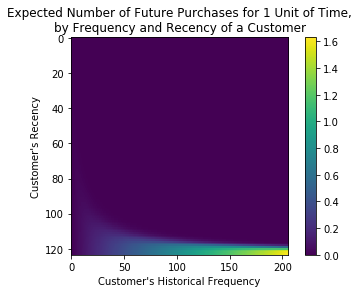

In [274]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

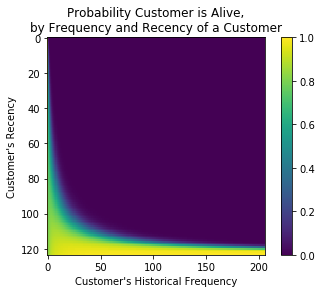

In [275]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [276]:
t = 4
m['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, m['frequency'], m['recency'], m['T'])
m.sort_values(by='predicted_purchases').tail(15)

,frequency,recency,T,predicted_purchases
customer,,,,
CUS-D3250964,50,52.0,52.0,3.589551
CUS-W-CN-04423160,51,53.0,53.0,3.596733
CUS-W-XS-92125017,53,55.0,55.0,3.610367
CUS-W-SF-00895675,42,42.0,42.0,3.676830
CUS-W-VN-03185864,55,56.0,56.0,3.684190
CUS-M6004676,71,72.0,72.0,3.750390
CUS-W-KR-76690240,38,32.0,33.0,4.029404
CUS-W-DS-33226215,67,58.0,59.0,4.202991
CUS-H2911406,86,76.0,76.0,4.317024


In [277]:
m['predicted_purchases'].sum()

4974.4719218408291

In [278]:
m.reset_index()
m.head()

,frequency,recency,T,predicted_purchases
customer,,,,
CUS-A0013083,2,50.0,72.0,0.087832
CUS-A0016193,0,0.0,11.0,0.065445
CUS-A0022539,0,0.0,60.0,0.014235
CUS-A0028640,0,0.0,24.0,0.033479
CUS-A0032874,7,6.0,48.0,0.000017


# Backtest

In [279]:
#Make a subset 
data_test = data_s[data_s['date'] < datetime(2017,1,1)]

#Check the latest date
data_test['date'].max()

Timestamp('2016-12-31 00:00:00')

In [287]:
g_test = data_test[data_test['isvalid']>0].groupby('customer').apply(lambda x: x['isvalid'].sum()).reset_index()
g_test.columns = ['customer','validOrders']
p_test = data_test[data_test['isvalid']>0].groupby('customer')['date'].agg({"first": lambda x: x.min(),"last": lambda x: x.max()}).reset_index()

In [288]:
print(g_test.shape)
print(p_test.shape)
merged_test = pd.merge(left=g_test,right=p_test,how='inner',left_on='customer',right_on='customer',copy=True)
print(merged_test.shape)
merged_test.head()

(30725, 2)
(30725, 3)
(30725, 4)


,customer,validOrders,first,last
0,CUS-A0013083,3,2015-10-12,2016-09-27
1,CUS-A0016193,1,2016-12-12,2016-12-12
2,CUS-A0022539,1,2016-01-06,2016-01-06
3,CUS-A0028640,1,2016-09-09,2016-09-09
4,CUS-A0032874,8,2016-03-31,2016-05-14


In [297]:
merged_test["T"] = (pd.datetime(2017,1,1) - merged_test['first']).astype('timedelta64[W]')
merged_test['recency'] = (merged_test['last'] - merged_test['first']).astype('timedelta64[W]')
merged_test['frequency'] = merged_test['validOrders'] - 1
merged_test.shape

(30725, 7)

In [298]:
m_test = merged_test[['customer','frequency','recency','T']].set_index('customer')
m_test.shape

(30725, 3)

In [299]:
bgf_test = BetaGeoFitter(penalizer_coef=0.0)
bgf_test.fit(m_test['frequency'], m_test['recency'], m_test['T'])
print(bgf_test)

<lifetimes.BetaGeoFitter: fitted with 30725 subjects, a: 0.62, alpha: 2.28, b: 2.85, r: 0.23>


In [300]:
t = 4
m_test['predicted_purchases'] = bgf_test.conditional_expected_number_of_purchases_up_to_time(t, m_test['frequency'], m_test['recency'], m_test['T'])
m_test.sort_values(by='predicted_purchases').tail(15)

,frequency,recency,T,predicted_purchases
customer,,,,
CUS-W-VN-03185864,46,47.0,48.0,3.482096
CUS-M6004676,62,62.0,63.0,3.653980
CUS-V5982835,49,46.0,47.0,3.779015
CUS-H2911406,74,66.0,68.0,3.886419
CUS-P1335085,40,36.0,36.0,4.023221
CUS-W-KR-76690240,29,24.0,24.0,4.185678
CUS-W-DS-33226215,57,50.0,50.0,4.239196
CUS-C3489321,37,28.0,29.0,4.363398
CUS-F4899355,16,11.0,11.0,4.386858


In [309]:
print((3270+1253+329 - m_test['predicted_purchases'].sum())/m_test['predicted_purchases'].sum())
m_test['predicted_purchases'].sum()

0.0968169041793


4423.7100846204494